In [3]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [45]:
test_df = pd.read_csv("./Titanic/test.csv")
train_df = pd.read_csv("./Titanic/train.csv")

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [46]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data preprocessing
### 1) Age and cabin have NaN values
### 2) Convert features to numeric
### 3) feature scaling

In [7]:
# Fields with missing values
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isna().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


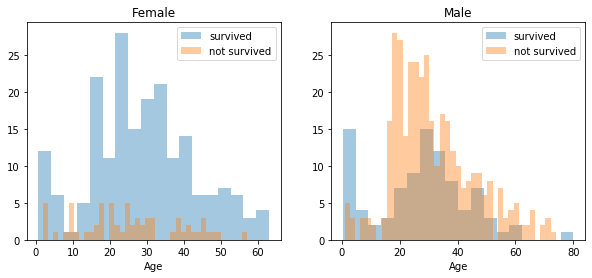

In [44]:
# I feel everything other than PassengerId , ticket and name should have to do with survival rate
# Eg : Age and sex
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

# Since there seem to be certain ages, which have increased odds of survival and 
# because I want every feature to be roughly on the same scale, I will create age groups later on

/home/gibraan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


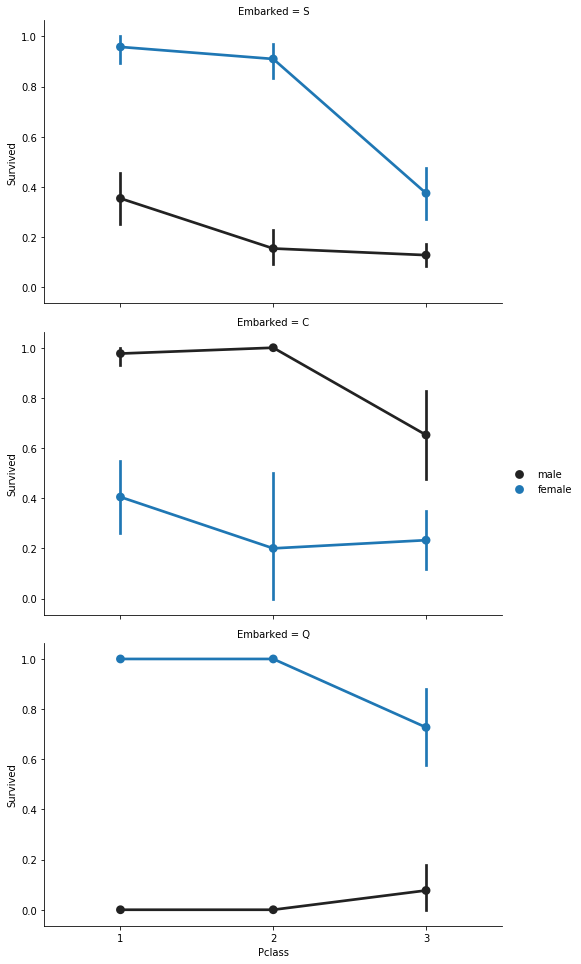

In [47]:
# Checking correlation between Embarked , Pclass and sex
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

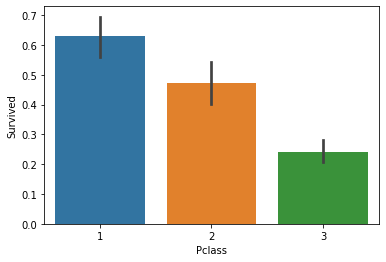

In [10]:
# Checking correlation with Pclass
sns.barplot(x='Pclass', y='Survived', data=train_df)

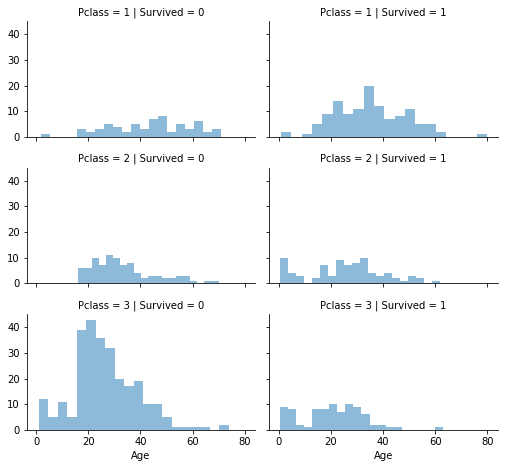

In [11]:
# Pclass vs Age
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [12]:
# SibSp and Parch would make more sense as a combined feature, 
# that shows the total number of relatives, a person has on the Titanic.
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

/home/gibraan/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


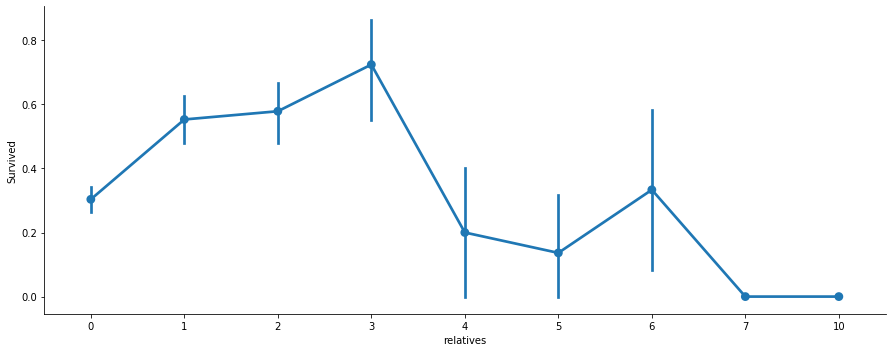

In [13]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

# Data preprocessing begins

In [14]:
# Dropping PassengerID because it has no effect on person's survival probability
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

In [15]:
# Handling missing data in Cabin column
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [16]:
# handling missing data of Age feature
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
    
train_df["Age"].isnull().sum()

0

In [17]:
# Handling missing data of Embarked feature
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [18]:
# Since only 2 missing values , replace them with most common ones
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [19]:
# So , now all columns have non null values for all records
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


In [20]:
# Converting Fare from float64 to int64
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [21]:
# Extracting titles from names to build new feature out of it 

data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [22]:
# Converting sex into numeric
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [23]:
# Examining ticket feature
train_df['Ticket'].describe()
# Handling it will be tricky , so I dropped it

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [24]:
# Converting Embarked into numeric
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

# Creating categories

In [25]:
# categories for age
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [26]:
train_df['Age'].value_counts()

6    166
5    158
4    157
3    135
2    107
1    100
0     68
Name: Age, dtype: int64

In [27]:
# For Fare similar to Age , but not exactly because if done so
# 80% of instances would fall into one of the classes .
# That is why using qcut()

data = [train_df, test_df]


for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# Creating 2 new features out of existing features

In [28]:
# 1) Age x class
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [29]:
# 2) Fare per person
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [30]:
# Final look at data 
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,A/5 21171,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,PC 17599,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,STON/O2. 3101282,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,113803,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,373450,1,0,0,1,8,1,15,1


# Training ML models finally !

In [31]:
# Splitting into training and testing data set
X_train = train_df.drop(["Survived","Ticket"], axis=1)
Y_train = train_df["Survived"]
#X_test  = test_df.drop("PassengerId", axis=1).copy()
X_test = test_df.drop("Ticket",axis=1).copy()

In [32]:
# Logistic Regression
logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)

81.59


In [33]:
# Stochastic Gradient Descent
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
print(acc_sgd)

78.68


In [34]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)

92.7


In [35]:
# K Nearest Neighbour
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(acc_knn)

86.53


In [36]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(acc_gaussian)

77.55


In [37]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree)

92.7


## Which is best model ?

In [38]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
92.70,Random Forest
92.70,Decision Tree
86.53,KNN
81.59,Logistic Regression
78.68,Stochastic Gradient Decent
77.55,Naive Bayes


In [39]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [40]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,A/5 21171,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,PC 17599,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,STON/O2. 3101282,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,113803,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,373450,1,0,0,1,8,1,15,1
